<a href="https://colab.research.google.com/github/TheReallyBigApple/CunyAssignments/blob/main/Data604/queue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                       CUNY MSDS Data604 Week 5
#                            Tom Buonora

# Modeling and Simulation in Python

Case Study: Queueing theory

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

# import functions from the modsim.py module
from modsim import *

# set the random number generator
np.random.seed(7)

ERROR:root:The 'ast_node_interactivity' trait of a Shell instance expected any of ['all', 'last', 'last_expr', 'none'], not the str 'last_expr_or_assign'.


Downloaded modsim.py


## One queue or two?

This notebook presents a solution to an exercise from *Modeling and Simulation in Python*.  It uses features from the first four chapters to answer a question related to queueing theory, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by how much.  Simulation can help answer this question.

As we did in the bikeshare model, we'll assume that a customer is equally likely to arrive during any timestep.  I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average.  But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.

### One server, one queue

Write a function called `make_system` that takes `lam` and `mu` as parameters and returns a `System` object with variables `lam`, `mu`, and `duration`.  Set `duration`, which is the number of time steps to simulate, to 10 hours, expressed in minutes. 

In [3]:
# lam : the arrival rate
# mu : the departure rate

def  make_system(lam,  mu):
    system = System(lam=lam, mu=mu, duration=10*60)
    return system

Test this function by creating a `System` object with `lam=1/8` and `mu=1/5`.

In [4]:
s = make_system(lam=1/8,mu=1/5)
print(s)

System(duration=600, lam=0.125, mu=0.2)


Write an update function that takes as parameters `x`, which is the total number of customer in the store, including the one checking out; `t`, which is the number of minutes that have elapsed in the simulation, and `system`, which is a `System` object.

If there's a customer checking out, it should use `flip` to decide whether they are done.  And it should use `flip` to decide if a new customer has arrived.

It should return the total number of customers at the end of the time step.


In [5]:
# This function represents one unit of time
#       x : no. of customers in store, including the one checkingout
#       t : minutes elapsed
#       s : system of arrival and departure rates

def update_func(x, t, s):
    if x > 0:
        if flip(s.mu):
            x=x-1

    if flip(s.lam):
        x=x+1
    return x
        

Test your function by calling it with `x=1`, `t=0`, and the `System` object you created.  If you run it a few times, you should see different results.

In [6]:
x= update_func(x=1, t=0, s=s)
print(x)
x= update_func(x=1, t=0, s=s)
print(x)
x= update_func(x=1, t=0, s=s)
print(x)

0
1
1


Now we can run the simulation.  Here's a version of `run_simulation` that creates a `TimeSeries` with the total number of customers in the store, including the one checking out.

In [7]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

Call `run_simulation` with your update function and plot the results.

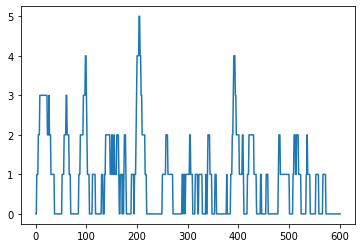

In [10]:
r = run_simulation(s, update_func)
import matplotlib.pyplot as plt
plt.plot(r)

After the simulation, we can compute `L`, which is the average number of customers in the system, and `W`, which is the average time customers spend in the store.  `L` and `W` are related by Little's Law:

$L = \lambda W$

Where $\lambda$ is the arrival rate.  Here's a function that computes them.

In [16]:
def compute_metrics(results, system):
    """Compute average number of customers and wait time.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

Call `compute_metrics` with the results from your simulation.

In [ ]:
L,W = compute_metrics(r,s)
print("The mean of results is ", L)
print("The mean divided by arrival rate is the average time spent in the store", W)

### Parameter sweep

Since we don't know the actual value of $\lambda$, we can sweep through a range of possibilities, from 10% to 80% of the completion rate, $\mu$.  (If customers arrive faster than the completion rate, the queue grows without bound.  In that case the metrics `L` and `W` just depend on how long the store is open.)

Create an array of values for `lam`.

In [13]:
l_array = np.arange(0.1*s.mu, 0.8*s.mu, .01)
print(s.mu)
print(l_array)

0.2
[0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15
 0.16]


Write a function that takes an array of values for `lam`, a single value for `mu`, and an update function.

For each value of `lam`, it should run a simulation, compute `L` and `W`, and store the value of `W` in a `SweepSeries`.

It should return the `SweepSeries`.

In [11]:
def sweep_lam(l_array, mu, update_func):
  s = SweepSeries()

  for l in l_array:
    system = make_system(l, mu)
    results = run_simulation(system, update_func)
    L, W = compute_metrics(results, system)
    s[l] = W

  return s



Call your function to generate a `SweepSeries`, and plot it.

In [21]:
r = sweep_lam(l_array, s.mu, update_func)


<br><font color="purple">I tried this a few times. Its choppy but as arrival rate increases, W increases. </font><br>

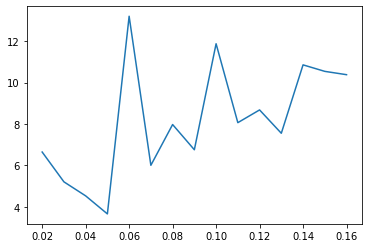

In [22]:
plt.plot(r)

If we imagine that this range of values represents arrival rates on different days, we can use the average value of `W`, for a range of values of `lam`, to compare different queueing strategies.

In [36]:
W_avg = r.mean()
W_avg

8.053519124532412

### Analysis

The model I chose for this system is a common model in queueing theory, in part because many of its properties can be derived analytically.

In particular, we can derive the average time in the store as a function of $\mu$ and $\lambda$:

$W = 1 / (\mu - \lambda)$

The following function plots the theoretical value of $W$ as a function of $\lambda$.

In [40]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W = 1 / (mu - lam_array)
    plt.plot(lam_array, W, 'g-')

Use this function to plot the theoretical results, then plot your simulation results again on the same graph.  How do they compare?

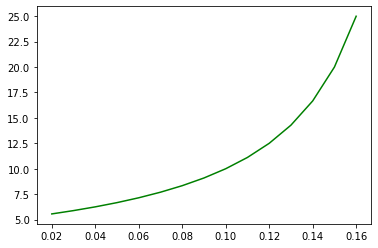

In [41]:
plot_W(l_array, s.mu)

<br><font color="purple">As the arrival rate increases relative to departure rate the longer customers must wait</font><br>

<br><font color="purple">If I compare this W plot to the previous W plot, they are a different calculation. The previous one was schochastic and choppy, this one was has no random element to it</font><br>

### Multiple servers

Now let's try the other two queueing strategies:

1.  One queue with two checkout counters.
2.  Two queues, one for each counter.

The following figure shows the three scenarios:

![](diagrams/queue.png)

Write an update function for one queue with two servers.

In [42]:


   # do the same thing only handle departures on 2 queues
def update_func2(x, t, system):
  
    if x > 1 and flip(system.mu):
        x -= 1
    
    if x > 0 and flip(system.mu):
        x = x - 1

    if flip(system.lam):
        x = x + 1
        
    return x


Use this update function to simulate the system, plot the results, and print the metrics.

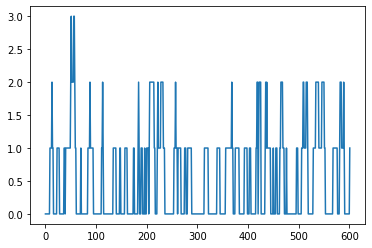

In [44]:
r = run_simulation(s, update_func2)
plt.plot(r)
  

Since we have two checkout counters now, we can consider values for $\lambda$ that exceed $\mu$.

Create a new array of values for `lam` from 10% to 160% of `mu`.

In [25]:

l_array = np.arange(0.1*s.mu, 1.6*s.mu, .01)
print(l_array)

[0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15
 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29
 0.3  0.31 0.32]


Use your sweep function to simulate the two server, one queue scenario with a range of values for `lam`.

Plot the results and print the average value of `W` across all values of `lam`.

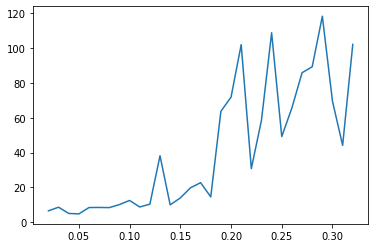

In [26]:
r = sweep_lam(l_array, s.mu, update_func)
plt.plot(r)

In [47]:
W_avg = r.mean()
W_avg

44.284591575145804

### Multiple queues

To simulate the scenario with two separate queues, we need two state variables to keep track of customers in each queue.

Write an update function that takes `x1`, `x2`, `t`, and `system` as parameters and returns `x1` and `x2` as return values.  f you are not sure how to return more than one return value, see `compute_metrics`.

When a customer arrives, which queue do they join?

In [27]:
def update_func3(x1, x2, t, s):
    if x1 > 0 and flip(s.mu):
        x1 -= 1

    if x2 > 0 and flip(s.mu):
        x2 -= 1

    if flip(s.lam):
        if x1 < x2:
            x1 += 1
        else:
            x2 += 1
    return x1, x2

Write a version of `run_simulation` that works with this update function.

In [32]:
def run_simulation2(system, update_func):
    x1, x2 = 0, 0
    results = TimeSeries()
    results[0] = x1 + x2
    
    for t in linrange(0, system.duration):
        x1, x2 = update_func(x1, x2, t, system)
        results[t+1] = x1 + x2
        
    return results 

Test your functions by running a simulation with a single value of `lam`.

In [35]:
s.lam=.5
run_simulation2(s, update_func3)

Time
0       0
1       1
2       1
3       1
4       1
       ..
597    65
598    63
599    64
600    64
601    64
Name: Quantity, Length: 602, dtype: int64

Sweep a range of values for `lam`, plot the results, and print the average wait time across all values of `lam`.

How do the results compare to the scenario with two servers and one queue.

In [ ]:
l_array = np.arange(0.1*s.mu, s.mu, .01)


In [36]:

def sweep_lam2(l_array, mu, update_func):
  s = SweepSeries()

  for l in l_array:
    system = make_system(l, mu)
    results = run_simulation2(system, update_func)
    L, W = compute_metrics(results, system)
   
    s[l] = W

  return s

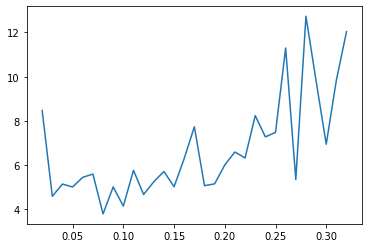

In [39]:

r = sweep_lam2(l_array, s.mu, update_func3)
plt.plot(r)


<br><font color="purple">This stochastic W plot shows a lower overall wait time</font><br>